In [1]:
import numpy as np
import xarray as xr
from glob import glob
import cosima_cookbook as cc
import matplotlib.pyplot as plt

In [2]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 180.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39223,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 180.00 GiB
Comm: tcp://127.0.0.1:43519,Total threads: 4
Dashboard: /proxy/39511/status,Memory: 45.00 GiB
Nanny: tcp://127.0.0.1:42519,


In [3]:
# database for control simulation:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
control = '01deg_jra55v13_ryf9091'
#expt_qian = '01deg_jra55v13_ryf9091_qian_wthp'

# database for ssp585_wind_thermal simulation
expt_session =cc.database.create_session('/g/data/e14/hd4873/access-om2-01/project03_cmip6_forcing/databases/wind-thermal_trial.db')
expt_ssp585 = '01deg_jra55v13_ssp585_windthermal'
expt_ssp245 = '01deg_jra55v13_ssp245_windthermal'

In [4]:
def shelf_mask_isobath(var):
    '''
    Masks ACCESS-OM2-01 variables by the region polewards of the 1000m isobath as computed using 
    a script contributed by Adele Morrison.
    Only to be used with ACCESS-OM2-0.1 output!
    '''
    contour_file = np.load('/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz')
    
    shelf_mask = contour_file['contour_masked_above']
    yt_ocean = contour_file['yt_ocean']
    xt_ocean = contour_file['xt_ocean']
    
    # in this file the points along the isobath are given a positive value, the points outside (northwards) 
    # of the isobath are given a value of -100 and all the points on the continental shelf have a value of 0 
    # so we mask for the 0 values 
    shelf_mask[np.where(shelf_mask!=0)] = np.nan
    shelf_mask = shelf_mask+1
    shelf_map = np.nan_to_num(shelf_mask)
    shelf_mask = xr.DataArray(shelf_mask, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    shelf_map = xr.DataArray(shelf_map, coords = [('yt_ocean', yt_ocean), ('xt_ocean', xt_ocean)])
    
    # then we want to multiply the variable with the mask so we need to account for the shape of the mask. 
    # The mask uses a northern cutoff of 59S.
    masked_var = var.sel(yt_ocean = slice(-90, -59.03)) * shelf_mask
    return masked_var, shelf_map

# Whole shelf timeseries

In [17]:
start_time = '2150-01-01'
end_time = '2158-12-31'
time_slice = slice(start_time, end_time)
lat_slice = slice(-80,-60)
#z_slice = slice(0,3000)
#months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

variables = ['temp','salt','dzt','area_t']

# read in CONTROL data
temp_cntl = cc.querying.getvar(control,variables[0],master_session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)-273.15
salt_cntl = cc.querying.getvar(control,variables[1],master_session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)
dzt_cntl = cc.querying.getvar(control,variables[2],master_session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)
area_t_cntl = cc.querying.getvar(control,variables[3],master_session,n=1).sel(yt_ocean=lat_slice)
# read in SSP585 data
temp_ssp585 = cc.querying.getvar(expt_ssp585,variables[0],expt_session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)-273.15
salt_ssp585 = cc.querying.getvar(expt_ssp585,variables[1],expt_session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)
dzt_ssp585 = cc.querying.getvar(expt_ssp585,variables[2],expt_session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)
area_t_ssp585 = cc.querying.getvar(expt_ssp585,variables[3],expt_session,n=1).sel(yt_ocean=lat_slice)
# read in SSP245 data
temp_ssp245 = cc.querying.getvar(expt_ssp245,variables[0],expt_session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)-273.15
salt_ssp245 = cc.querying.getvar(expt_ssp245,variables[1],expt_session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)
dzt_ssp245 = cc.querying.getvar(expt_ssp245,variables[2],expt_session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)
area_t_ssp245 = cc.querying.getvar(expt_ssp245,variables[3],expt_session,n=1).sel(yt_ocean=lat_slice)


# mask to shelf
# CONTROL
#temp_cntl, shelf_map = shelf_mask_isobath(temp_cntl)
salt_cntl, shelf_map = shelf_mask_isobath(salt_cntl)
dzt_cntl, shelf_map = shelf_mask_isobath(dzt_cntl)
area_t_cntl, shelf_map = shelf_mask_isobath(area_t_cntl)
# SSP585
temp_ssp585, shelf_map = shelf_mask_isobath(temp_ssp585)
salt_ssp585, shelf_map = shelf_mask_isobath(salt_ssp585)
dzt_ssp585, shelf_map = shelf_mask_isobath(dzt_ssp585)
area_t_ssp585, shelf_map = shelf_mask_isobath(area_t_ssp585)
# SSP245
temp_ssp245, shelf_map = shelf_mask_isobath(temp_ssp245)
salt_ssp245, shelf_map = shelf_mask_isobath(salt_ssp245)
dzt_ssp245, shelf_map = shelf_mask_isobath(dzt_ssp245)
area_t_ssp245, shelf_map = shelf_mask_isobath(area_t_ssp245)

In [7]:
%%time
# calculate volume of shelf grid cells
vol_cntl = dzt_cntl*area_t_cntl
vol_ssp585 = dzt_ssp585*area_t_ssp585
vol_ssp245 = dzt_ssp245*area_t_ssp245
#volume = volume.load()
vol_sum_cntl = vol_cntl.sum('xt_ocean').sum('yt_ocean').sum('st_ocean').load()
vol_sum_ssp585 = vol_ssp585.sum('xt_ocean').sum('yt_ocean').sum('st_ocean').load()
vol_sum_ssp245 = vol_ssp245.sum('xt_ocean').sum('yt_ocean').sum('st_ocean').load()
#print(vol_sum_cntl , vol_sum_ssp585)

CPU times: user 8min 55s, sys: 29.9 s, total: 9min 25s
Wall time: 17min 1s


In [8]:
%%time
# calculate volume averaged temperature and salinity
temp_cntl = (temp_cntl*vol_cntl).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/vol_sum_cntl
temp_cntl = temp_cntl.load()
temp_cntl

CPU times: user 4min 40s, sys: 12.5 s, total: 4min 52s
Wall time: 5min 41s


<xarray.DataArray (time: 108)>
array([-1.0580292 , -0.9920364 , -1.0279114 , -1.10363   , -1.1715038 ,
       -1.209916  , -1.2421937 , -1.2630914 , -1.2738389 , -1.277382  ,
       -1.2639866 , -1.1849942 , -1.0603417 , -0.9946444 , -1.0297501 ,
       -1.1040862 , -1.1709901 , -1.2080073 , -1.2392676 , -1.2611475 ,
       -1.2715241 , -1.2748111 , -1.2618971 , -1.1839108 , -1.0600272 ,
       -0.9946327 , -1.0318933 , -1.1073326 , -1.1738056 , -1.2111838 ,
       -1.2435149 , -1.2652335 , -1.2776241 , -1.2807386 , -1.2671403 ,
       -1.1879305 , -1.0634215 , -0.997544  , -1.0335839 , -1.1080475 ,
       -1.1737885 , -1.2110059 , -1.2414542 , -1.2608148 , -1.2695884 ,
       -1.2720596 , -1.2582582 , -1.1786464 , -1.0541219 , -0.9882185 ,
       -1.0238354 , -1.0985748 , -1.1653941 , -1.2032244 , -1.2356286 ,
       -1.2578872 , -1.2694641 , -1.2726809 , -1.2601272 , -1.182329  ,
       -1.0577555 , -0.9916842 , -1.0269121 , -1.1012743 , -1.165573  ,
       -1.2021805 , -1.2338055 , -1.2556266 , -1.2675561 , -1.270559  ,
       -1.2579322 , -1.1796058 , -1.0566294 , -0.99149746, -1.02659   ,
       -1.1008447 , -1.167551  , -1.2068694 , -1.2400051 , -1.2621228 ,
       -1.2731986 , -1.2763543 , -1.2640243 , -1.1857964 , -1.0610042 ,
       -0.99455434, -1.0300385 , -1.1050556 , -1.1698904 , -1.2073978 ,
       -1.239796  , -1.2610785 , -1.2719568 , -1.2743517 , -1.2611098 ,
       -1.1820481 , -1.0583375 , -0.9919336 , -1.0267663 , -1.1011786 ,
       -1.1660808 , -1.2027068 , -1.234774  , -1.2563394 , -1.2673918 ,
       -1.2713597 , -1.2582915 , -1.1788125 ], dtype=float32)
Coordinates:
  * time     (time) object 2150-01-16 12:00:00 ... 2158-12-16 12:00:00

In [9]:
%%time
# calculate volume averaged temperature and salinity
temp_ssp585 = (temp_ssp585*vol_ssp585).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/vol_sum_ssp585
temp_ssp585 = temp_ssp585.load()
#temp_ssp585

CPU times: user 6min 15s, sys: 19.5 s, total: 6min 35s
Wall time: 11min 29s


In [10]:
%%time
# calculate volume averaged temperature and salinity
temp_ssp245 = (temp_ssp245*vol_ssp245).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/vol_sum_ssp245
temp_ssp245 = temp_ssp245.load()
#temp_ssp245

CPU times: user 7min 22s, sys: 23.7 s, total: 7min 46s
Wall time: 13min 39s


In [18]:
%%time
# calculate volume averaged temperature and salinity
salt_cntl = (salt_cntl*vol_cntl).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/vol_sum_cntl
salt_cntl = salt_cntl.load()
#salt_cntl

NameError: name 'vol_cntl' is not defined

In [19]:
%%time
# calculate volume averaged temperature and salinity
salt_ssp585 = (salt_ssp585*vol_ssp585).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/vol_sum_ssp585
salt_ssp585 = salt_ssp585.load()
#salt_ssp585

NameError: name 'vol_ssp585' is not defined

In [20]:
%%time
# calculate volume averaged temperature and salinity
salt_ssp245 = (salt_ssp245*vol_ssp245).sum('xt_ocean').sum('yt_ocean').sum('st_ocean')/vol_sum_ssp245
salt_ssp245 = salt_ssp245.load()
#salt_ssp245

NameError: name 'vol_ssp245' is not defined

#### Temperature plot

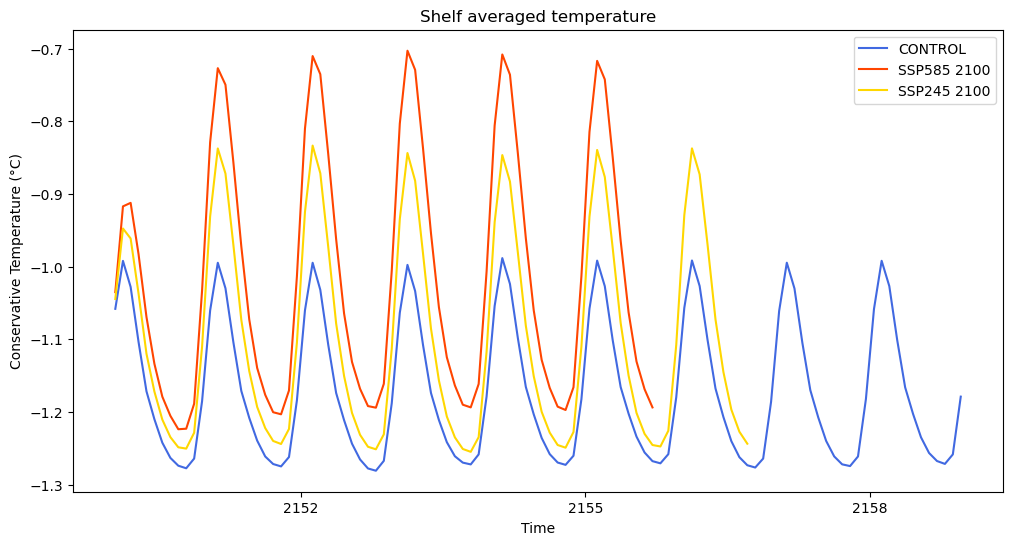

In [11]:
fig = plt.figure(figsize=(12,6))
temp_cntl.plot(c='royalblue', label='CONTROL')
temp_ssp585.plot(c='orangered', label='SSP585 2100')
temp_ssp245.plot(c='gold', label='SSP245 2100')
plt.ylabel('Conservative Temperature (\u00b0C)')
plt.xlabel('Time')
plt.title('Shelf averaged temperature')
plt.legend()
plt.show()

figfile = '../figs/timeseries_shelf_temperature.jpg'
#fig.savefig(figfile, dpi=200)

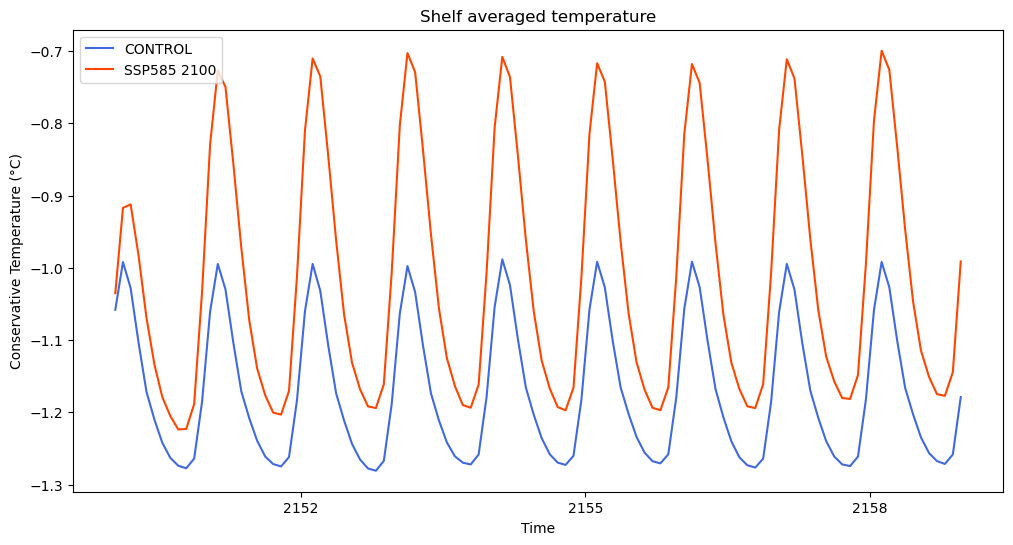

In [31]:
fig = plt.figure(figsize=(12,6))
temp_cntl.plot(c='royalblue', label='CONTROL')
temp_expt.plot(c='orangered', label='SSP585 2100')
plt.ylabel('Conservative Temperature (\u00b0C)')
plt.xlabel('Time')
plt.title('Shelf averaged temperature')
plt.legend()
plt.show()

figfile = '../figs/timeseries_shelf_temperature.jpg'
fig.savefig(figfile, dpi=200)

#### Salinity Plot

In [ ]:
fig = plt.figure(figsize=(12,6))
salt_cntl.plot(c='royalblue', label='CONTROL')
salt_ssp585.plot(c='orangered', label='SSP585 2100')
salt_ssp245.plot(c='gold', label='SSP245 2100')
plt.ylabel('Salinity (psu)')
plt.xlabel('Time')
plt.title('Shelf averaged salinity')
plt.ylim([34.32, 34.55])
plt.legend()
plt.show()

figfile = '../figs/timeseries_shelf_salinity.jpg'
fig.savefig(figfile, dpi=200)

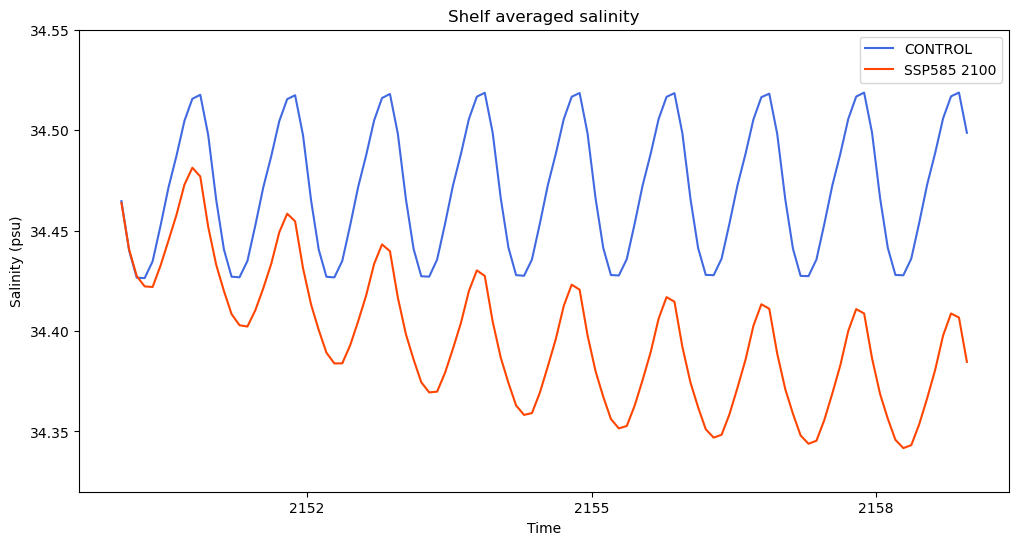

In [22]:
fig = plt.figure(figsize=(12,6))
salt_cntl.plot(c='royalblue', label='CONTROL')
salt_expt.plot(c='orangered', label='SSP585 2100')
plt.ylabel('Salinity (psu)')
plt.xlabel('Time')
plt.title('Shelf averaged salinity')
plt.ylim([34.32, 34.55])
plt.legend()
plt.show()

figfile = '../figs/timeseries_shelf_salinity.jpg'
fig.savefig(figfile, dpi=200)

# Bottom shelf timeseries

In [5]:
def select_bottom(ds, depth_array, max_depth):
    bottom_ds = ds.where(depth_array.st_ocean >= max_depth)
    bottom_ds = bottom_ds.sum(dim = 'st_ocean')
    bottom_ds = bottom_ds.load()
    
    return bottom_ds

In [6]:
start_time = '2150-01-01'
end_time = '2158-12-31'
time_slice = slice(start_time, end_time)
lat_slice = slice(-80,-60)
#z_slice = slice(0,3000)
#months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])

variables = ['temp','salt','dzt','area_t']

# read in CONTROL data
temp_cntl = cc.querying.getvar(control,variables[0],master_session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)-273.15
salt_cntl = cc.querying.getvar(control,variables[1],master_session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)
dzt_cntl = cc.querying.getvar(control,variables[2],master_session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)
area_t_cntl = cc.querying.getvar(control,variables[3],master_session,n=1).sel(yt_ocean=lat_slice)
# read in SSP585 data
temp_ssp585 = cc.querying.getvar(expt_ssp585,variables[0],expt_session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)-273.15
salt_ssp585 = cc.querying.getvar(expt_ssp585,variables[1],expt_session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)
dzt_ssp585 = cc.querying.getvar(expt_ssp585,variables[2],expt_session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)
area_t_ssp585 = cc.querying.getvar(expt_ssp585,variables[3],expt_session,n=1).sel(yt_ocean=lat_slice)
# read in SSP245 data
temp_ssp245 = cc.querying.getvar(expt_ssp245,variables[0],expt_session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)-273.15
salt_ssp245 = cc.querying.getvar(expt_ssp245,variables[1],expt_session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)
dzt_ssp245 = cc.querying.getvar(expt_ssp245,variables[2],expt_session,frequency='1 monthly',start_time=start_time, end_time=end_time).sel(time=time_slice).sel(yt_ocean=lat_slice)
area_t_ssp245 = cc.querying.getvar(expt_ssp245,variables[3],expt_session,n=1).sel(yt_ocean=lat_slice)

# mask to shelf
# CONTROL
temp_cntl, shelf_map = shelf_mask_isobath(temp_cntl)
salt_cntl, shelf_map = shelf_mask_isobath(salt_cntl)
dzt_cntl, shelf_map = shelf_mask_isobath(dzt_cntl)
area_t_cntl, shelf_map = shelf_mask_isobath(area_t_cntl)
# SSP585
temp_ssp585, shelf_map = shelf_mask_isobath(temp_ssp585)
salt_ssp585, shelf_map = shelf_mask_isobath(salt_ssp585)
dzt_ssp585, shelf_map = shelf_mask_isobath(dzt_ssp585)
area_t_ssp585, shelf_map = shelf_mask_isobath(area_t_ssp585)
# SSP245
temp_ssp245, shelf_map = shelf_mask_isobath(temp_ssp245)
salt_ssp245, shelf_map = shelf_mask_isobath(salt_ssp245)
dzt_ssp245, shelf_map = shelf_mask_isobath(dzt_ssp245)
area_t_ssp245, shelf_map = shelf_mask_isobath(area_t_ssp245)

In [7]:
%%time
print("selecting bottom values")
# select out bottom values:
depth_array = temp_cntl * 0 + temp_cntl.st_ocean
max_depth = depth_array.max(dim = 'st_ocean', skipna= True)
print('CONTROL')
bottom_temp_cntl = select_bottom(temp_cntl, depth_array, max_depth)
bottom_salt_cntl = select_bottom(salt_cntl, depth_array, max_depth)
print('SSP585')
bottom_temp_ssp585 = select_bottom(temp_ssp585, depth_array, max_depth)
bottom_salt_ssp585 = select_bottom(salt_ssp585, depth_array, max_depth)
print('SSP245')
bottom_temp_ssp245 = select_bottom(temp_ssp245, depth_array, max_depth)
bottom_salt_ssp245 = select_bottom(salt_ssp245, depth_array, max_depth)

selecting bottom values


/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/dask/array/reductions.py:651: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/dask/array/reductions.py:651: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/dask/array/reductions.py:651: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-23.04/lib/python3.9/site-packages/dask/array/reductions.py:651: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


CPU times: user 25min 40s, sys: 1min 21s, total: 27min 1s
Wall time: 41min 23s


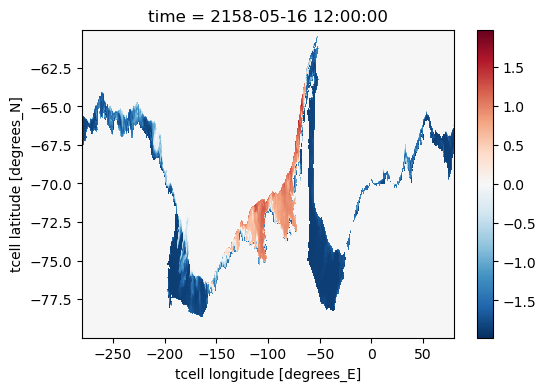

In [8]:
bottom_temp_cntl.isel(time=100).plot(figsize=(6,4)); plt.show()

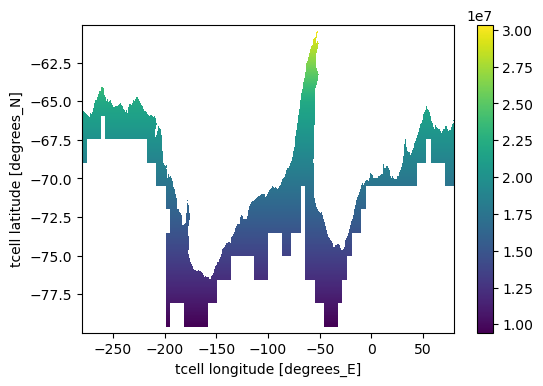

In [9]:
area_t_cntl.plot(figsize=(6,4)); plt.show()

In [10]:
%%time
# calculate area sum of shelf grid cells
area_sum_cntl = area_t_cntl.sum('xt_ocean').sum('yt_ocean').load()
area_sum_ssp585 = area_t_ssp585.sum('xt_ocean').sum('yt_ocean').load()
area_sum_ssp245 = area_t_ssp245.sum('xt_ocean').sum('yt_ocean').load()

CPU times: user 364 ms, sys: 61.9 ms, total: 426 ms
Wall time: 949 ms


In [11]:
%%time
# calculate area averaged temperature and salinity
bottom_temp_cntl = (bottom_temp_cntl*area_t_cntl).sum('xt_ocean').sum('yt_ocean')/area_sum_cntl
bottom_temp_cntl = bottom_temp_cntl.load()

bottom_salt_cntl = (bottom_salt_cntl*area_t_cntl).sum('xt_ocean').sum('yt_ocean')/area_sum_cntl
bottom_salt_cntl = bottom_salt_cntl.load()

CPU times: user 4.66 s, sys: 4.17 s, total: 8.83 s
Wall time: 9.45 s


In [12]:
%%time
# calculate volume averaged temperature and salinity
bottom_temp_ssp585 = (bottom_temp_ssp585*area_t_ssp585).sum('xt_ocean').sum('yt_ocean')/area_sum_ssp585
bottom_temp_ssp585 = bottom_temp_ssp585.load()

bottom_salt_ssp585 = (bottom_salt_ssp585*area_t_ssp585).sum('xt_ocean').sum('yt_ocean')/area_sum_ssp585
bottom_salt_ssp585 = bottom_salt_ssp585.load()

CPU times: user 3.02 s, sys: 2.67 s, total: 5.69 s
Wall time: 5.95 s


In [13]:
%%time
# calculate volume averaged temperature and salinity
bottom_temp_ssp245 = (bottom_temp_ssp245*area_t_ssp245).sum('xt_ocean').sum('yt_ocean')/area_sum_ssp245
bottom_temp_ssp245 = bottom_temp_ssp245.load()

bottom_salt_ssp245 = (bottom_salt_ssp245*area_t_ssp245).sum('xt_ocean').sum('yt_ocean')/area_sum_ssp245
bottom_salt_ssp245 = bottom_salt_ssp245.load()

CPU times: user 3.47 s, sys: 2.97 s, total: 6.44 s
Wall time: 6.87 s


#### Temperature Plot

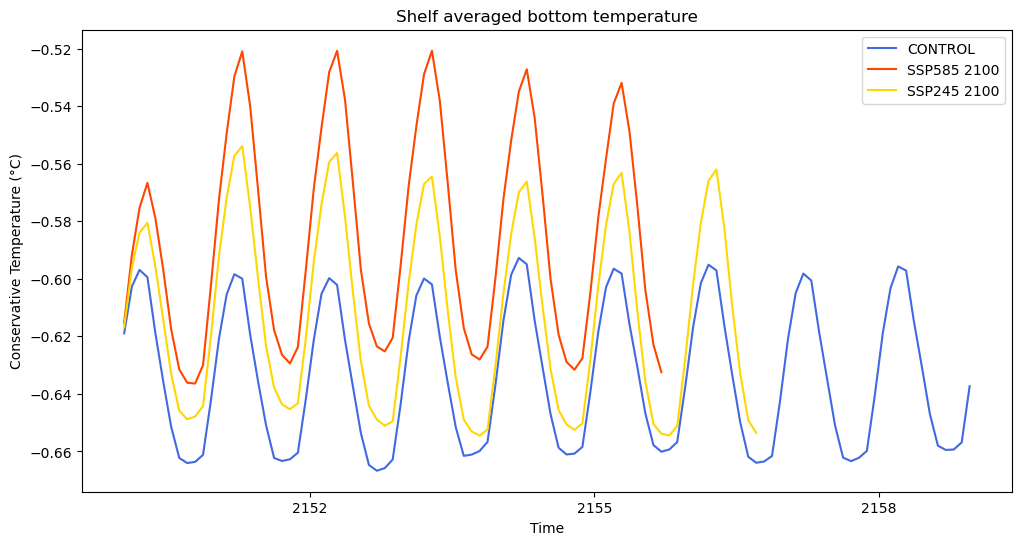

In [14]:
fig = plt.figure(figsize=(12,6))
bottom_temp_cntl.plot(c='royalblue', label='CONTROL')
bottom_temp_ssp585.plot(c='orangered', label='SSP585 2100')
bottom_temp_ssp245.plot(c='gold', label='SSP245 2100')
plt.ylabel('Conservative Temperature (\u00b0C)')
plt.xlabel('Time')
plt.title('Shelf averaged bottom temperature')
plt.legend()
plt.show()

figfile = '../figs/timeseries_bottom_shelf_temperature.jpg'
fig.savefig(figfile, dpi=200)

#### Salinity Plot

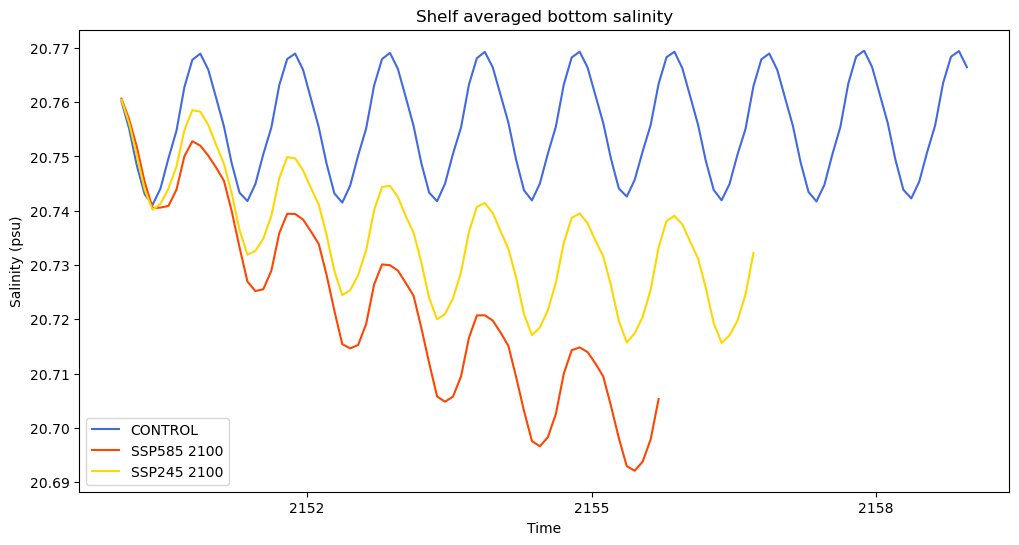

In [16]:
fig = plt.figure(figsize=(12,6))
bottom_salt_cntl.plot(c='royalblue', label='CONTROL')
bottom_salt_ssp585.plot(c='orangered', label='SSP585 2100')
bottom_salt_ssp245.plot(c='gold', label='SSP245 2100')
plt.ylabel('Salinity (psu)')
plt.xlabel('Time')
plt.title('Shelf averaged bottom salinity')
#plt.ylim([34.32, 34.55])
plt.legend()
plt.show()

figfile = '../figs/timeseries_bottom_shelf_salinity.jpg'
fig.savefig(figfile, dpi=200)